# Trabalho 1 - Reconhecimento de Padrões
Aluno: Luis Felipe Carneiro de Souza

Matrícula: 535049

> Os códigos deste trabalho foram desenvolvido com bases no material em MATLAB/OCTAVE disponibilizado pelo professor

importação de bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

Lendo o conjunto de dados como um DataFrame

In [2]:
data = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-1/vertebral%2Bcolumn/column_3C.dat"

conjunto = pd.read_csv(data, header=None, sep='\s+')
conjunto = conjunto.sample(frac=1)
conjunto.head()

,0,1,2,3,4,5,6
233,40.68,9.15,31.02,31.53,139.12,-2.51,NO
247,49.83,16.74,28.00,33.09,121.44,1.91,NO
89,71.19,23.90,43.70,47.29,119.86,27.28,SL
55,47.66,13.28,36.68,34.38,98.25,6.27,DH
166,56.99,6.87,57.01,50.12,109.98,36.81,SL


Separando o conjunto de dados entre variáveis de entrada e variáveis resposta

In [3]:
x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

Dicionário de proporção de separação entre conjunto de treino e teste

In [4]:
sep = {'20/80': {'train': 0.2, 'test': 0.8},
       '30/70': {'train': 0.3, 'test': 0.7},
       '50/50': {'train': 0.5, 'test': 0.5},
       '70/30': {'train': 0.7, 'test': 0.3},
       '80/20': {'train': 0.8, 'test': 0.2}}

Funções coveninentes 

In [5]:
def calcular_estatisticas(lista_acuracias):
    """Calcula estatísticas descritivas de umas lista de acurácias"""
    return {
        'media': np.nanmean(lista_acuracias),
        'desvio': np.nanstd(lista_acuracias),
        'mediana': np.nanmedian(lista_acuracias),
        'minimo': np.nanmin(lista_acuracias),
        'maximo': np.nanmax(lista_acuracias),
    }

from sklearn.metrics import confusion_matrix
import numpy as np

def compilar_resultados(historico_acc, stats_classes, tempo_decorrido, melhor_acc, pior_acc, melhor_dados, pior_dados, classes):
    """
    Consolida os dados brutos do experimento em um dicionário de resultados padronizado.
    """
    
    # Gera as matrizes de confusão aqui dentro para limpar o loop principal
    matriz_melhor = confusion_matrix(
        y_true=melhor_dados['y_true'], 
        y_pred=melhor_dados['y_pred'], 
        labels=classes
    )

    matriz_pior = confusion_matrix(
        y_true=pior_dados['y_true'], 
        y_pred=pior_dados['y_pred'], 
        labels=classes
    )

    return {
        'historico_acuracia': historico_acc,
        'media': np.mean(historico_acc),
        'desvio': np.std(historico_acc),
        'minimo': np.min(historico_acc),
        'maximo': np.max(historico_acc),
        'stats_por_classe': stats_classes,
        'tempo': tempo_decorrido,
        'melhor_rodada_acc': melhor_acc,
        'pior_rodada_acc': pior_acc,
        'matriz_confusao_melhor': matriz_melhor,
        'matriz_confusao_pior': matriz_pior,
        'classes': classes
    }

### Classificador Vizinho Mais Próximo (distância de Minkowski de ordens m ∈ {0,5; 2/3; 1; 3/2; 2; 5/2})

**Sobre a implementação:**

Loops aninhados que iteram sobre a separação entre conjunto de treino e teste, e variação do parâmetro da distância de Minkowski

In [26]:
resultados_knn = {} # dicionário para armazenar os resultados
C = np.sort(conjunto.iloc[:, -1].unique()) # classes presentes no conjunto de dados

x_norm = 2 * (x - x.min()) / (x.max() - x.min()) - 1

total_tqdm = len(sep.keys()) * len([0.5, 2/3, 1, 3/2, 2, 5/2]) * len(range(100))
with tqdm.tqdm(total=total_tqdm, desc='KNN progress') as pbar:

    for s in sep.keys(): # diferentes proporções de separação treino/teste
        resultados_knn[s] = {}
        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        for m in [0.5, 2/3, 1, 3/2, 2, 5/2]: # diferentes ordens da distância de Minkowski

            acc_por_classe_lists = {classe: [] for classe in C}
            Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
            inicio = time.perf_counter()

            # variaveis para rastrear a melhor e pior rodada
            melhor_acc = -1.0
            pior_acc = 2.0
            melhor_rodada_dados = {'y_true': [], 'y_pred': []}
            pior_rodada_dados = {'y_true': [], 'y_pred': []}

            for rep in range(100): # 100 rodadas de treino

                pbar.update(1)    

                x_norm = x_norm.sample(frac=1) # embaralha as amostras
                y = y.loc[x_norm.index] # embaralha as classes

                x_trn, y_trn = x_norm.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
                x_tst, y_tst = x_norm.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

                class_hits = {classe: 0 for classe in C}
                class_totals = {classe: 0 for classe in C}

                # lista para armazenar previsões desta rodada específica
                y_true_rodada = []
                y_pred_rodada = []

                acerto = 0 # contador de acertos
                for i in range(len(x_tst)):
                    x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                    y_true = y_tst.iloc[i] # classe da nova amostra

                    dist_array = []
                    for j in range(len(x_trn)):
                        dist_array.append(minkowski(x_new, np.array(x_trn.iloc[j, :]), p=m)) # distância de Minkowski de ordem m
                    
                    j_min = np.argmin(dist_array) # índice do menor valor de distância
                    y_pred = y_trn.iloc[j_min]

                    # armazena os resultados da amostra
                    y_true_rodada.append(y_true)
                    y_pred_rodada.append(y_pred)

                    class_totals[y_true] += 1
                    if y_pred == y_true: # verifica se a classificação foi correta
                        acerto += 1
                        class_hits[y_true] += 1
            
                acc_rodada_atual = acerto / len(x_tst)
                Pacerto.append(acerto / len(x_tst)) # calcula a porcentagem de acertos

                if acc_rodada_atual > melhor_acc:
                    melhor_acc = acc_rodada_atual
                    melhor_rodada_dados['y_true'] = y_true_rodada
                    melhor_rodada_dados['y_pred'] = y_pred_rodada
                if acc_rodada_atual < pior_acc:
                    pior_acc = acc_rodada_atual
                    pior_rodada_dados['y_true'] = y_true_rodada
                    pior_rodada_dados['y_pred'] = y_pred_rodada

                for classe in C:
                    total = class_totals[classe]
                    hits = class_hits[classe]

                    if total > 0:
                        acc_da_classe_nesta_rodada = hits / total
                    else:
                        acc_da_classe_nesta_rodada = np.nan

                    acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)


            fim = time.perf_counter()

            stats_por_classe = {}
            for classe, lista_de_acuracias in acc_por_classe_lists.items():
                stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)

            # matriz da melhor rodada
            matriz_melhor = confusion_matrix(y_true=melhor_rodada_dados['y_true'], y_pred=melhor_rodada_dados['y_pred'], labels=C)

            # matriz da pior rodada
            matriz_pior = confusion_matrix(y_true=pior_rodada_dados['y_true'], y_pred=pior_rodada_dados['y_pred'], labels=C)

            resultados_knn[s][m] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)

KNN progress: 100%|██████████| 3000/3000 [31:34<00:00,  1.58it/s]


### Classificador Distância Mínima ao Centróide

In [30]:
resultados_mdc = {}
C = np.sort(conjunto.iloc[:, -1].unique()) # classes presentes no conjunto de dados

x_norm = 2 * (x - x.min()) / (x.max() - x.min()) - 1

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x_norm = x_norm.sample(frac=1)
            y = y.loc[x_norm.index]
            
            x_trn, y_trn = x_norm.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x_norm.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.mean()

            acerto = 0 # contador de acertos
            for i in range(len(x_tst)): # loop que itera sobre o conjunto de teste
                x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.iloc[i] # classe da nova amostra

                dist_array = []
                for k in C:
                    #print(x_new, np.array(centroides[k]))
                    dist_array.append(minkowski(x_new, np.array(centroides[k]), p=2)) # distância Euclidiana ao centróide da classe k
                
                k_min = np.argmin(dist_array) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)


        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        resultados_mdc[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)
    #resultados_centroide

MDC progress: 100%|██████████| 500/500 [00:05<00:00, 86.06it/s] 


### Classificador Distância Mínima ao Centróide (versão robusta a outliers)

In [31]:
resultados_mdc_robusto = {}
C = np.sort(conjunto.iloc[:, -1].unique())

x_norm = 2 * (x - x.min()) / (x.max() - x.min()) - 1

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC robust progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x_norm = x_norm.sample(frac=1)
            y = y.loc[x_norm.index]
            
            x_trn, y_trn = x_norm.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x_norm.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.median()

            acerto = 0 # contador de acertos
            for i in range(len(x_tst)):
                x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.iloc[i] # classe da nova amostra

                dist_array = []
                for k in C:
                    #print(x_new, np.array(centroides[k]))
                    dist_array.append(minkowski(x_new, np.array(centroides[k]), p=1)) # distância quarteirao ao centróide da classe k
                
                k_min = np.argmin(dist_array) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)

        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        resultados_mdc_robusto[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)
    #resultados_centroide_robusto

MDC robust progress: 100%|██████████| 500/500 [00:06<00:00, 77.22it/s] 


### Classificador de Máxima Correlação

In [32]:
resultados_max_corr = {}
C = np.sort(conjunto.iloc[:, -1].unique())

norms = np.linalg.norm(x.values, axis=1, keepdims=True)

x_norm = pd.DataFrame(x.values / norms, index=x.index, columns=x.columns)

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x_norm = x_norm.sample(frac=1)
            y = y.loc[x_norm.index]
            
            x_trn, y_trn = x_norm.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x_norm.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.mean()

            acerto = 0 # contador de acertos
            for i in x_tst.index:
                x_new = np.array(x_tst.loc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.loc[i] # classe da nova amostra

                sim = []
                for k in C:
                    sim.append(np.dot(x_new, np.array(centroides[k]))) # distância Euclidiana ao centróide da classe k
                
                k_min = np.argmax(sim) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)


        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )

        resultados_max_corr[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)

MDC progress: 100%|██████████| 500/500 [00:04<00:00, 101.44it/s]


Salvando arquivos em pickle

In [33]:
import pickle

# 1. Agrupe todos os seus resultados em um único dicionário "pacote"
# Certifique-se de usar os nomes exatos das variáveis que você criou
dados_para_salvar = {
    'knn': resultados_knn,
    'mdc': resultados_mdc,
    'mdc_robusto': resultados_mdc_robusto,  # Verifique o nome da sua variável
    'max_corr': resultados_max_corr         # Verifique o nome da sua variável
}

# 2. Defina o nome do arquivo
nome_arquivo = 'backup_resultados_trabalho1.pkl'

# 3. Salva no disco (modo 'wb' = write binary)
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(dados_para_salvar, arquivo)

print(f"Dados salvos com sucesso em '{nome_arquivo}'!")

Dados salvos com sucesso em 'backup_resultados_trabalho1.pkl'!


acessando novamente os arquivos pickle

In [6]:
import pickle

# 1. Nome do arquivo que você salvou
nome_arquivo = 'backup_resultados_trabalho1.pkl'

# 2. Carrega do disco (modo 'rb' = read binary)
try:
    with open(nome_arquivo, 'rb') as arquivo:
        dados_carregados = pickle.load(arquivo)
    
    print("Dados recuperados com sucesso!")
    
    # 3. Restaura as variáveis individuais para usar nos seus gráficos
    resultados_knn = dados_carregados['knn']
    resultados_mdc = dados_carregados['mdc']
    resultados_mdc_robusto = dados_carregados['mdc_robusto']
    resultados_max_corr = dados_carregados['max_corr']
    
    # Agora você pode rodar o código dos gráficos direto daqui!
    
except FileNotFoundError:
    print(f"Erro: O arquivo '{nome_arquivo}' não foi encontrado. Verifique o caminho.")

Dados recuperados com sucesso!


salvando em json

In [34]:
import json
import numpy as np

# Classe auxiliar para converter NumPy arrays em listas Python
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # Transforma array em lista comum
        if isinstance(obj, np.integer):
            return int(obj)     # Transforma int do numpy em int do python
        if isinstance(obj, np.floating):
            return float(obj)   # Transforma float do numpy em float do python
        return super(NumpyEncoder, self).default(obj)

# Seus dados (mesmo dicionário que usamos antes)
dados_para_salvar = {
    'knn': resultados_knn,
    'mdc': resultados_mdc,
    'mdc_robusto': resultados_mdc_robusto,
    'max_corr': resultados_max_corr
}

# Salva usando o codificador personalizado
nome_arquivo_json = 'backup_resultados_trabalho1.json'
with open(nome_arquivo_json, 'w') as f:
    json.dump(dados_para_salvar, f, cls=NumpyEncoder, indent=4) # indent=4 deixa legível

print(f"Salvo em JSON com sucesso: {nome_arquivo_json}")

Salvo em JSON com sucesso: backup_resultados_trabalho1.json


### Resultados

In [25]:
import pandas as pd

# 1. Liste todos os seus dicionários de resultados aqui
# Formato: ('Nome do Classificador', Dicionario_de_Resultados)
# OBS: Para o KNN, como ele tem sub-chaves (k=1, k=3...), o tratamento é automático no loop abaixo se ele seguir o padrão.
fontes_dados = [
    ('KNN', resultados_knn), 
    ('MDC', resultados_mdc), 
    ('MDC_Robusto', resultados_mdc_robusto), # Ajuste o nome da variável conforme seu código
    ('Max_Correlacao', resultados_max_corr)  # Ajuste o nome da variável conforme seu código
]

registros = []

for nome_base, dicionario in fontes_dados:
    # Itera sobre as separações (20/80, 50/50, etc.)
    for separacao, dados_sep in dicionario.items():
        
        # Verifica se dentro da separação existem sub-parâmetros (como o 'k' do KNN)
        # Se as chaves forem números (ex: 1, 3, 5) ou strings de parâmetros, é um nível extra.
        # Se já tiver chaves como 'media', 'desvio', então é o resultado direto.
        
        primeira_chave = list(dados_sep.keys())[0]
        
        if isinstance(dados_sep[primeira_chave], dict):
            # Caso COM sub-parâmetros (Ex: KNN com k=1, k=3...)
            for param, metricas in dados_sep.items():
                nome_completo = f"{nome_base} (k={str(param)})"
                # Adiciona cada uma das 100 rodadas como uma linha (para o Boxplot)
                for acc in metricas['historico_acuracia']:
                    registros.append({
                        'Classificador': nome_completo,
                        'Separacao': separacao,
                        'Acuracia': acc
                    })
        else:
            # Caso SEM sub-parâmetros (Ex: MDC)
            metricas = dados_sep
            nome_completo = nome_base
            for acc in metricas['historico_acuracia']:
                registros.append({
                    'Classificador': nome_completo,
                    'Separacao': separacao,
                    'Acuracia': acc
                })

# Cria o DataFrame Mestre com TODAS as rodadas
df_boxplot = pd.DataFrame(registros)
df_boxplot['Classificador'] = df_boxplot['Classificador'].replace(
        'KNN (k=0.6666666666666666)', 
        'KNN (k=2/3)'
    )

# Cria um DataFrame Resumo (só médias) para a Tabela
df_resumo = df_boxplot.groupby(['Separacao', 'Classificador'])['Acuracia'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
df_resumo.columns = ['Separação', 'Classificador', 'Média', 'Desvio', 'Mínimo', 'Máximo', 'Mediana']
df_resumo['Classificador'] = df_resumo['Classificador'].replace(
    'KNN (k=0.6666666666666666)', 
    'KNN (k=2/3)'
)

In [26]:
df_resumo

,Separação,Classificador,Média,Desvio,Mínimo,Máximo,Mediana
0,20/80,KNN (k=0.5),0.710645,0.026120,0.629032,0.774194,0.711694
1,20/80,KNN (k=1),0.715000,0.030250,0.649194,0.790323,0.713710
2,20/80,KNN (k=1.5),0.722016,0.027100,0.653226,0.774194,0.723790
3,20/80,KNN (k=2),0.716492,0.027758,0.641129,0.778226,0.717742
4,20/80,KNN (k=2.5),0.720565,0.028859,0.649194,0.782258,0.723790
5,20/80,KNN (k=2/3),0.708266,0.027815,0.620968,0.766129,0.711694
6,20/80,MDC,0.728306,0.024192,0.653226,0.782258,0.729839
7,20/80,MDC_Robusto,0.707621,0.028573,0.629032,0.782258,0.709677
8,20/80,Max_Correlacao,0.710040,0.049155,0.596774,0.798387,0.709677
9,30/70,KNN (k=0.5),0.720276,0.021118,0.672811,0.778802,0.718894


In [27]:
# Configuração para mostrar a tabela bonita no notebook
pd.set_option('display.max_rows', None)

print("=== TABELA DE RESULTADOS GERAIS (Ordenada por Acurácia Média) ===")
# Ordena por Média (Decrescente)
display(df_resumo.sort_values(by='Média', ascending=False).style.background_gradient(cmap='Greens', subset=['Média']))

=== TABELA DE RESULTADOS GERAIS (Ordenada por Acurácia Média) ===


,Separação,Classificador,Média,Desvio,Mínimo,Máximo,Mediana
37,80/20,KNN (k=1),0.764194,0.043058,0.645161,0.887097,0.758065
39,80/20,KNN (k=2),0.754355,0.054629,0.596774,0.903226,0.758065
41,80/20,KNN (k=2/3),0.753065,0.049312,0.596774,0.870968,0.758065
30,70/30,KNN (k=2),0.752258,0.034376,0.677419,0.849462,0.752688
28,70/30,KNN (k=1),0.752043,0.032594,0.677419,0.817204,0.752688
36,80/20,KNN (k=0.5),0.751290,0.046992,0.645161,0.887097,0.758065
38,80/20,KNN (k=1.5),0.748065,0.050371,0.629032,0.854839,0.758065
42,80/20,MDC,0.746129,0.046736,0.645161,0.838710,0.758065
44,80/20,Max_Correlacao,0.745323,0.052191,0.645161,0.903226,0.741935
31,70/30,KNN (k=2.5),0.745054,0.042030,0.602151,0.838710,0.741935


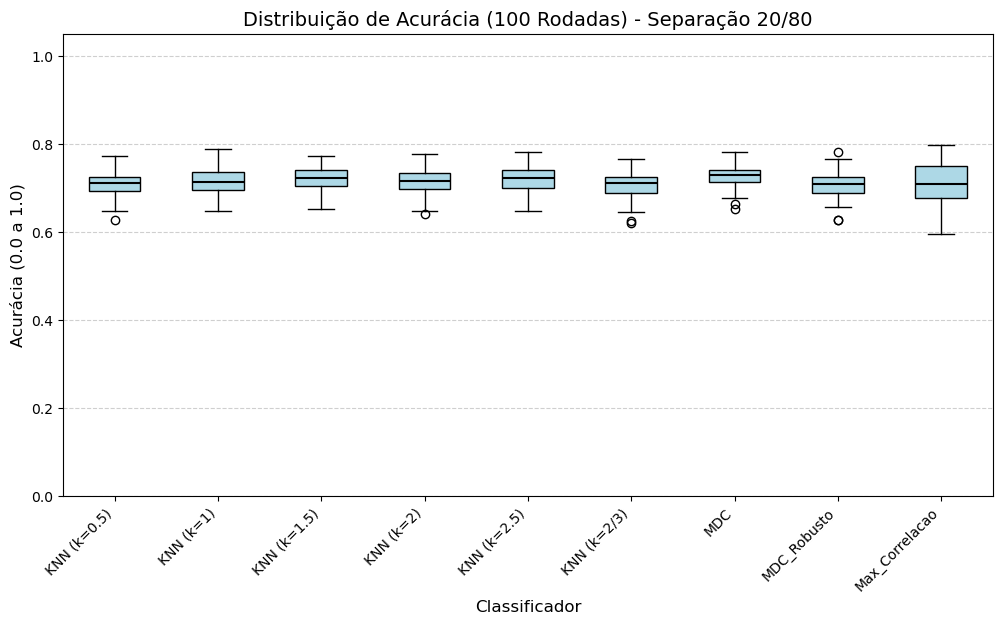

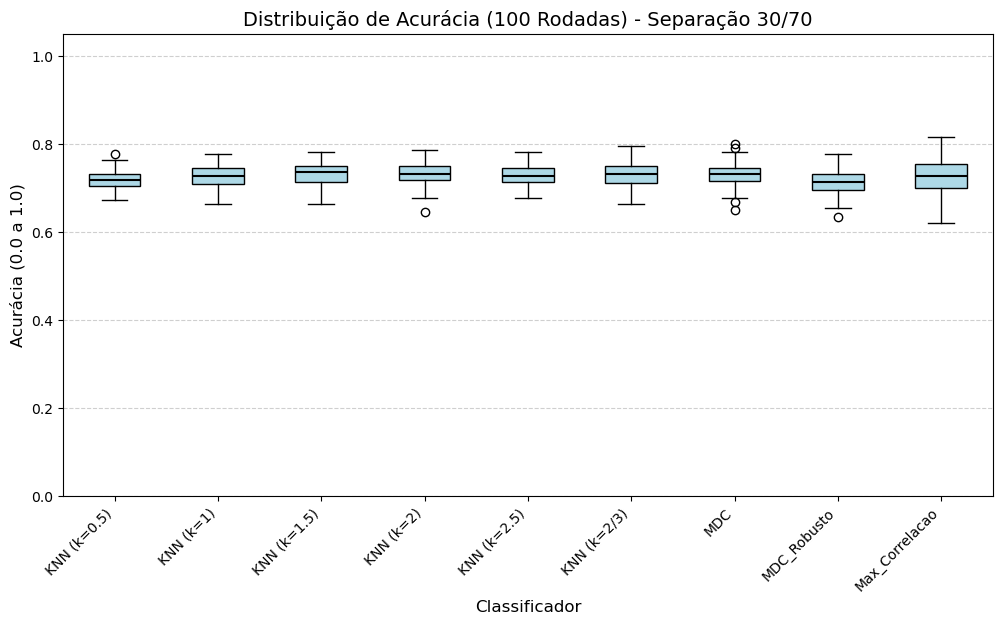

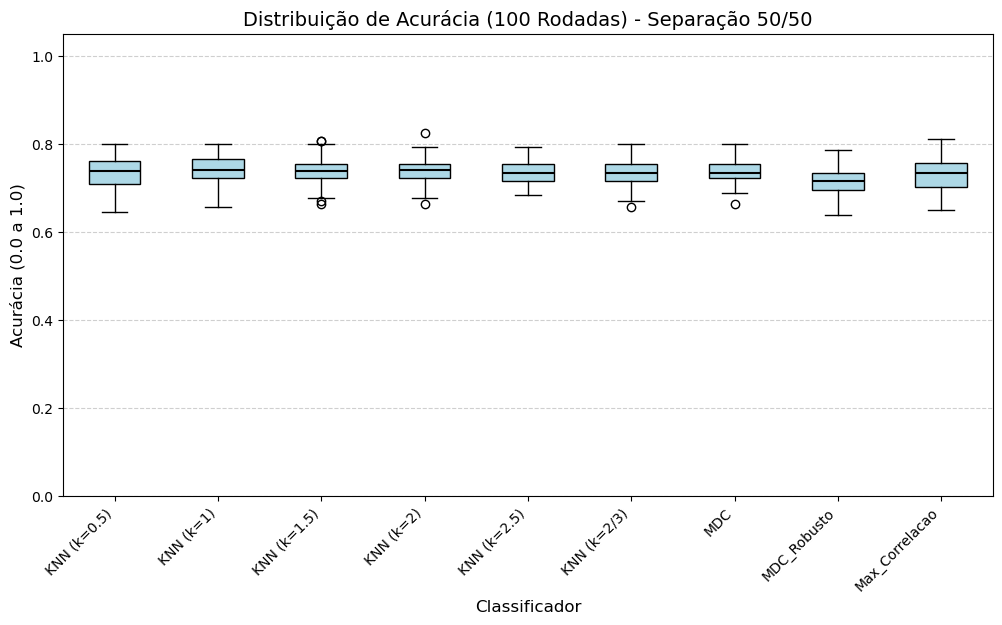

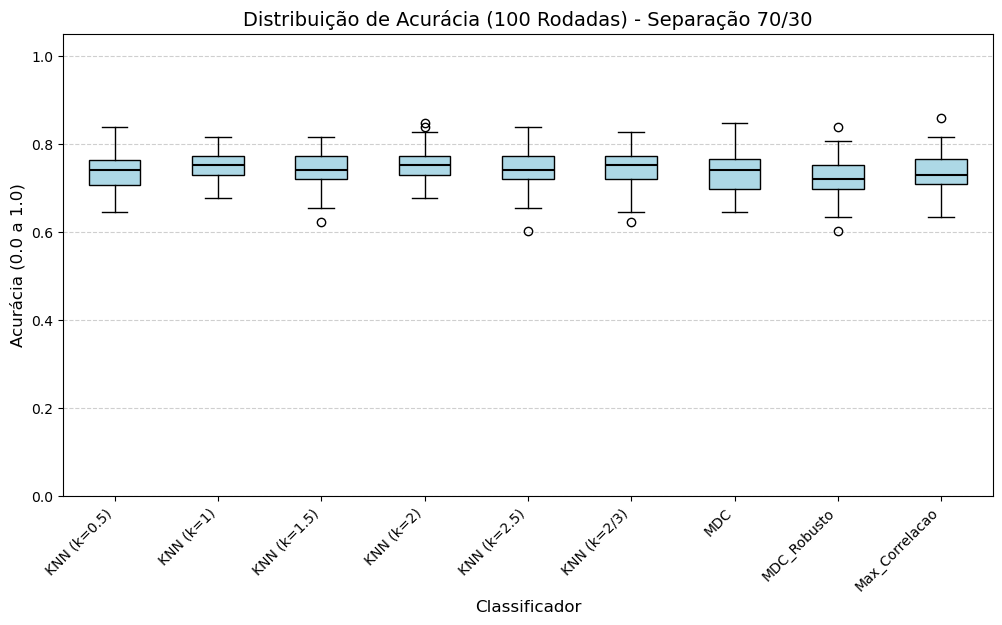

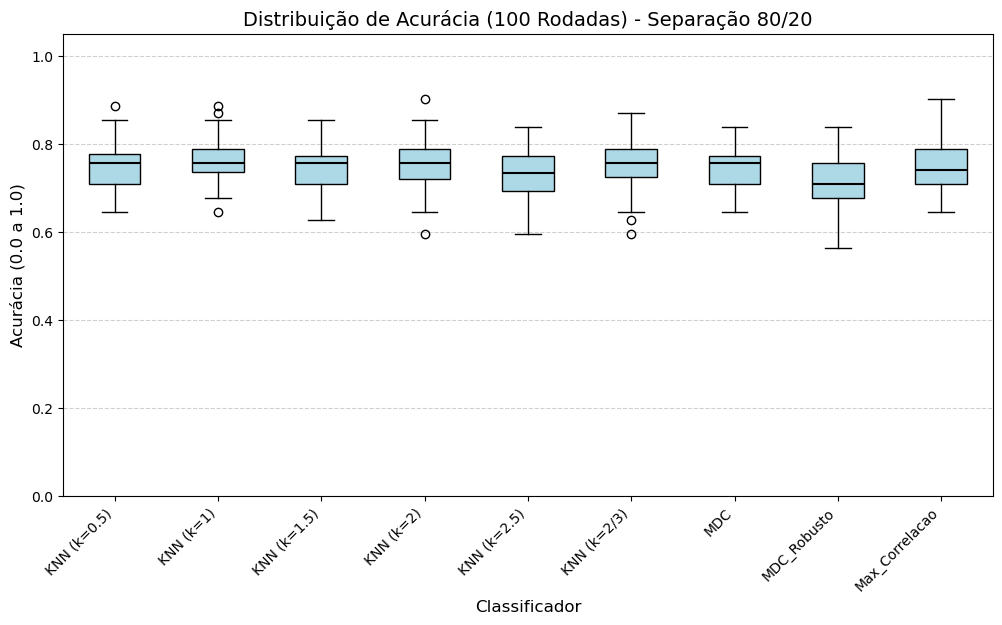

In [30]:
import matplotlib.pyplot as plt

# Obtém as separações únicas ordenadas
separacoes = sorted(df_boxplot['Separacao'].unique())

for sep in separacoes:
    # Filtra dados apenas dessa separação
    dados_sep = df_boxplot[df_boxplot['Separacao'] == sep]
    
    # Prepara os dados para o formato que o matplotlib exige (lista de arrays)
    nomes_classificadores = sorted(dados_sep['Classificador'].unique())
    dados_para_plotar = []
    labels = []
    
    for clf in nomes_classificadores:
        accs = dados_sep[dados_sep['Classificador'] == clf]['Acuracia'].values
        dados_para_plotar.append(accs)
        labels.append(clf)
    
    # --- PLOTAGEM COM MATPLOTLIB ---
    plt.figure(figsize=(12, 6)) # Tamanho da figura
    
    # Cria o Boxplot
    # patch_artist=True permite preencher as caixas com cor
    bplot = plt.boxplot(dados_para_plotar, tick_labels=labels, patch_artist=True, 
                        medianprops=dict(color="black", linewidth=1.5));
    
    # Colore as caixas para ficar visualmente agradável (opcional)
    colors = ['lightblue'] * len(labels)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    # Estilização
    plt.title(f'Distribuição de Acurácia (100 Rodadas) - Separação {sep}', fontsize=14)
    plt.ylabel('Acurácia (0.0 a 1.0)', fontsize=12)
    plt.xlabel('Classificador', fontsize=12)
    plt.ylim(0.0, 1.05) # Fixa o eixo Y de 0 a 100%
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    
    # Rotaciona os nomes dos classificadores se ficarem encavalados
    plt.xticks(rotation=45, ha='right')
    
    #plt.tight_layout()
    plt.show();

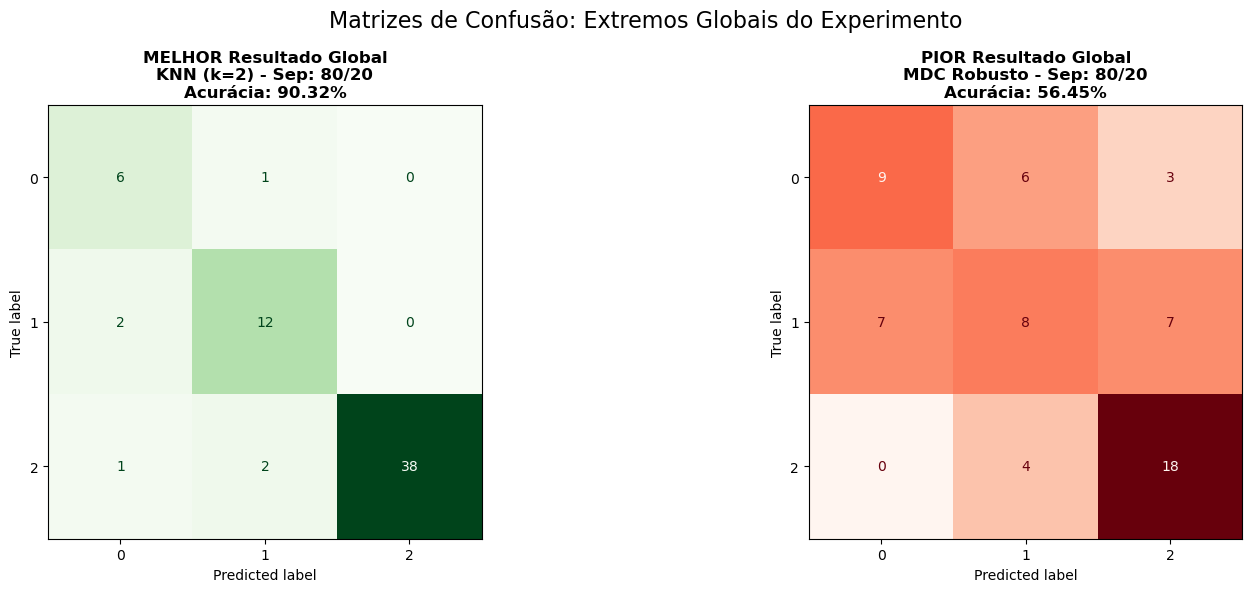

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Agrupar fontes de dados (caso ainda não tenha feito)
# Certifique-se de que os nomes das variáveis aqui correspondem aos seus dicionários
fontes_dados = [
    ('KNN', resultados_knn),
    ('MDC', resultados_mdc),
    ('MDC Robusto', resultados_mdc_robusto), # Verifique o nome correto da sua variável
    ('Max Correlação', resultados_max_corr)  # Verifique o nome correto da sua variável
]

# Variáveis para armazenar o campeão e o lanterna
melhor_global = {'acc': -1, 'matriz': None, 'titulo': ''}
pior_global   = {'acc': 2.0, 'matriz': None, 'titulo': ''} # 2.0 é impossível, só para iniciar

# 2. Varredura para encontrar a Melhor e a Pior rodada de TODAS
for nome_base, dicionario in fontes_dados:
    for separacao, dados in dicionario.items():
        
        # Tratamento para KNN que tem subníveis (k=1, k=3...)
        # Se a primeira chave for um dicionário, então tem subníveis
        primeira_chave = list(dados.keys())[0]
        
        # Lista de itens a verificar (se é KNN verifica os subníveis, se não, verifica o próprio)
        if isinstance(dados[primeira_chave], dict):
            iters = dados.items() # Ex: [(0.5, {...}), (1, {...})]
        else:
            iters = [(None, dados)] # Ex: [(None, {...})]

        for param, metricas in iters:
            # Constrói o nome legível
            if param is not None:
                # Ajuste para nome 2/3 ficar bonito
                param_str = "2/3" if (isinstance(param, float) and abs(param - 2/3) < 0.001) else str(param)
                nome_completo = f"{nome_base} (k={param_str})"
            else:
                nome_completo = nome_base

            # --- Verifica se é a MELHOR rodada global ---
            # Compara com o 'maximo' histórico ou 'melhor_rodada_acc' se você salvou
            acc_max_atual = metricas['maximo'] 
            if acc_max_atual > melhor_global['acc']:
                melhor_global['acc'] = acc_max_atual
                melhor_global['matriz'] = metricas['matriz_confusao_melhor']
                melhor_global['titulo'] = f"{nome_completo} - Sep: {separacao}"

            # --- Verifica se é a PIOR rodada global ---
            acc_min_atual = metricas['minimo']
            if acc_min_atual < pior_global['acc']:
                pior_global['acc'] = acc_min_atual
                pior_global['matriz'] = metricas['matriz_confusao_pior']
                pior_global['titulo'] = f"{nome_completo} - Sep: {separacao}"

# 3. Plotagem Lado a Lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Título Geral
fig.suptitle('Matrizes de Confusão: Extremos Globais do Experimento', fontsize=16)

# --- Gráfico 1: A Melhor Rodada de Todas ---
if melhor_global['matriz'] is not None:
    disp1 = ConfusionMatrixDisplay(confusion_matrix=melhor_global['matriz'])
    disp1.plot(ax=ax1, cmap='Greens', values_format='d', colorbar=False)
    ax1.set_title(f"MELHOR Resultado Global\n{melhor_global['titulo']}\nAcurácia: {melhor_global['acc']:.2%}", fontsize=12, fontweight='bold')
    # Adiciona texto dentro dos quadrados se o automático falhar, mas o plot() geralmente resolve.
else:
    ax1.text(0.5, 0.5, "Dados não encontrados", ha='center')

# --- Gráfico 2: A Pior Rodada de Todas ---
if pior_global['matriz'] is not None:
    disp2 = ConfusionMatrixDisplay(confusion_matrix=pior_global['matriz'])
    disp2.plot(ax=ax2, cmap='Reds', values_format='d', colorbar=False)
    ax2.set_title(f"PIOR Resultado Global\n{pior_global['titulo']}\nAcurácia: {pior_global['acc']:.2%}", fontsize=12, fontweight='bold')
else:
    ax2.text(0.5, 0.5, "Dados não encontrados", ha='center')

plt.tight_layout()
plt.show()